

<b>This code deals with the analysis used to produce figure 5 in "Storms drive outgassing of CO2 in the subpolar Southern Ocean" Nature Communications. </b>

Author: Sarah Nicholson

Date: 02 November 2021

In [15]:
%pylab inline
import xarray as xr
import dask
import pandas as pd
import airsea
import cmocean as cm
from cartopy import crs, feature
import xesmf as xe
from cartopy import crs as ccrs, feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy import crs as ccrs, feature as cfeature
import seaborn as sns

<b> First Load of Mask for subpolar regions </b>

In [22]:
fpath = '../Data/Generalisation/'
fname = 'zonal_masked_region.nc'
m = xr.open_dataarray(fpath+fname)
m = m[4:,:] 

# Step 1: Loading datasets required:

<b> NB: The following steps 1-2 require downloading and working with large datasets - hpc required. For resulting output of entrainment the user should skip to step 3. </b>

## Download JRA-55-Do winds to estimate XLD
download uas and vas from here: https://esgf-node.llnl.gov/search/input4mips/
To search, select "Target MIP" = "OMIP", "Institution ID" = "MRI", and "Source Version" = "1.4.0" among tabs on the left side.

In [ ]:
from glob import glob

ystart = 2005
yend = 2021
prefix = '/home/snicholson1/erth/DATA/JRA_WIND/'
suffix = 'uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_'
all_flist = []
for year_k in range(ystart, yend, 1):
    flist_year_k = glob(prefix + suffix + str(year_k) + '*.nc')
    all_flist += flist_year_k
jra = xr.open_mfdataset(all_flist,concat_dim = 'time',combine='nested')

so_i = find((jra.lat.values < -45 ) & (jra.lat.values > -68))
jra_so = xr.open_mfdataset(all_flist,concat_dim = 'time',combine='nested').isel(lat=so_i)
uas = jra_so.uas

suffix = 'vas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_'
all_flist = []
for year_k in range(ystart, yend, 1):
    flist_year_k = glob(prefix + suffix + str(year_k) + '*.nc')
    all_flist += flist_year_k
jra = xr.open_mfdataset(all_flist,concat_dim = 'time',combine='nested')

jra_so = xr.open_mfdataset(all_flist,concat_dim = 'time',combine='nested').isel(lat=so_i)
vas = jra_so.vas

## Regrid wind data too a coarser grid

In [ ]:
import xesmf as xe
ds_out = xr.Dataset({'lat': (['lat'], np.arange(mask.lat.min(), mask.lat.max()+1, 0.25)),
                     'lon': (['lon'], np.arange(mask.lon.min(), mask.lon.max()+1, 0.25)),
                    }
                   )
regridder = xe.Regridder(uas, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder

In [ ]:
uasr = regridder(uas)
del uas
vasr = regridder(vas)
del vas

## Calculate XLD based on friction velocity and relationship to xld refer to figure S5

In [ ]:
wspd = np.sqrt(uasr**2 + vasr**2)
tau = airsea.windstress.stress(wspd,drag='largepond')
slope = 4451.981976635973
xld = np.sqrt(tau/1025)*slope

## Load EN4.2.1 temperature and salinity profiles 
Download data from here: https://www.metoffice.gov.uk/hadobs/en4/download-en4-2-1.html

In [ ]:
ystart = 2005
yend = 2020
prefix = '/home/snicholson1/erth/DATA/EN4_2_1/'
suffix = 'EN.4.2.1.f.analysis.g10.'
all_flist = []
for year_k in range(ystart, yend, 1):
    flist_year_k = glob(prefix + suffix + str(year_k) + '*.nc')
    all_flist += flist_year_k
en421 = xr.open_mfdataset(all_flist,concat_dim = 'time',combine='nested')

so_i = find((en421.lat.values < -40 ) & (en421.lat.values > -65))
en421_so = xr.open_mfdataset(all_flist,concat_dim = 'time',combine='nested').isel(lat=so_i)
en421_so = en421_so.sortby('time')

en421_so_seasons = en421_so.groupby('time.season')


## Compute potential density 

In [ ]:
en421_so.lat
t,z,y,x = np.shape(en421_so.salinity)
lat2d = np.tile(en421_so.lat,[t,1])
lat3d = np.zeros((t,z,y,x))
for i in range(x):
    for zz in range(z):
        lat3d[:,zz,:,i] = lat2d
        
lon2d = np.tile(en421_so.lon,[t,1])
lon3d = np.zeros((t,z,y,x))
for j in range(y):
    for zz in range(z):
        lon3d[:,zz,:,i] = lat2d
        
t,z,y,x = np.shape(en421_so.salinity)
depth2d = np.tile(en421_so.depth,[t,1])
depth3d = np.zeros((t,z,y,x))
for i in range(x):
    for j in range(y):
        depth3d[:,:,j,i] = depth2d

In [ ]:
salt_abs = gsw.SA_from_SP(en421_so.salinity,depth3d,lon3d,lat3d)
dens0 = gsw.pot_rho_t_exact(salt_abs,en421_so.temperature-273.15,depth3d,0)

In [ ]:
dens0_1 = xr.DataArray(dens0,dims=('time','depth','lat','lon'),coords={'time':en421_so.time,'depth':en421_so.depth,'lat': en421_so.lat, 'lon': en421_so.lon})


## CALCULATE THE MLD

In [ ]:
def mld_profile(dens_or_temp, depth, thresh, ref_depth, mask=False):

    i = np.nanargmin(np.abs(depth - ref_depth))

    if np.isnan(dens_or_temp[i]):
        mld = np.nan
    else:
        dd = dens_or_temp - dens_or_temp[i]  # density difference
        dd[depth < ref_depth] = np.nan
        abs_dd = abs(dd - thresh)
        depth_idx = np.nanargmin(abs_dd)
        mld = depth[depth_idx]

    if mask:
        return depth <= mld
    else:
        return mld

In [ ]:
lm = np.ma.masked_invalid(en421_so.salinity[0,0,::])
t,z,y,x = np.shape(en421_so.salinity)
dens0_1 = dens0_1.rolling(depth=8,center=True,min_periods=2).median()
mld = np.zeros((t,y,x))
for i in range(x):
    for j in range(y):
        
        # ignore land
        if (lm.mask[j,i] == True):
            mld[:,j,i] = np.ones((t))*-9999
        else:
            for k in range(t):
                if (np.isnan(np.diff(dens0_1[k,:,j,i]))).all():                
                    mld[k,j,i] = -9999
                else:
                    mld[k,j,i] = mld_profile(dens0_1[k,:,j,i],depth3d[k,:,j,i],0.03,15)

In [ ]:
mld_1 = xr.DataArray(mld,dims=('time','lat','lon'),coords={'time':en421_so.time,'lat': en421_so.lat, 'lon': en421_so.lon})
mld_1.to_netcdf('mld_rho003_15m_EN421_2005_2019.nc')


## Load DIC data
DIC data available from here: https://digital.csic.es/handle/10261/200537


In [12]:
fpath = 'ADD_YOUR_PATH/'
fname = 'TCO2_NNGv2LDEO_climatology.nc'
dic_b = xr.open_dataset(fpath+fname)

ilat = (dic_b.latitude < -40 ) & (dic_b.latitude > -65 )
dic_broullon1 = dic_b.TCO2_NNGv2LDEO[:,ilat,:].T
dic_broullon = dic_broullon1.rename({'longitude': 'lon','latitude': 'lat'})

# Regrid data:
import xesmf as xe
ds_out = xr.Dataset({'lat': (['lat'], np.arange(m.lat.min(), m.lat.max()+1, 1)),
                     'lon': (['lon'], np.arange(m.lon.min(), m.lon.max()+1, 1)),
                    }
                   )
regridder = xe.Regridder(dic_broullon, ds_out, 'bilinear')
regridder.clean_weight_file()

dic_broullong = regridder(dic_broullon)#.values

Create weight file: bilinear_25x360_24x360.nc
Remove file bilinear_25x360_24x360.nc


<b>----------------------------------------------------------------------------------------

# STEP 2:  Entrainment


## Setup surface and subsurface reservoirs of DIC
### Reservoir fixed per year and depends on max MLD

In [14]:
dic_broullongm = dic_broullong.mean('time')
mldmax = mld.groupby('time.year').max()

In [16]:
depth_bg =dic_b.depth
y,x = np.shape(dic_broullong[0,0,::])
years = np.arange(2006,2020,1)
dic_dep2d = np.tile(depth_bg,[y,x])
dic1_0t= np.zeros((np.size(years),y,x))
dic1_1t= np.zeros((np.size(years),y,x))

for i in np.arange(np.size(years)):
        for j in np.arange(y):
                for k in np.arange(x):
                    h1_max =  mldmax[i,j,k]  
                    zres = np.nanargmin(np.abs(depth_bg.values - h1_max.values))
                    
                    #Surface reserviour 0-mld max
                    dic1_0t[i,j,k] = np.nanmean(dic_broullongm.values[0:zres,j,k])#.mean()
                    
                    #Sub surface reserviour mld_max: mld_max+1
                    dic1_1t[i,j,k] = np.nanmean(dic_broullongm.values[zres:zres+1,j,k])

    
dic1_0t[dic1_0t< 100]= np.nan


## Calculate the entrainment of DIC when XLD > MLDmax



Z_ent  = ∫ H × (1/ MLD_max × (DIC_deep - DIC_surf )× ∂XLD/∂t)dt		         


where using x =  XLD/MLD_max ,

H= 1,if x > 1  and  ∂XLD/∂t  > 0,	

H = 0,if x < 1 or  ∂XLD/∂t  < 0, 


In [19]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [20]:
# drop leap day from leap year to avoid issues:

xld_noleap = xld.sel(time=~((xld.time.dt.month == 2) & (xld.time.dt.day == 29)))

In [21]:

years = np.arange(2006,2020,1)
t,y,x = np.shape(xld[:,:,:])
dDIC = np.zeros((np.size(years),2920,y,x))
dTalk = np.zeros((np.size(years),2920,y,x))
entrain_dates = np.zeros((np.size(years),2920))
dtime = np.zeros((np.size(years),2920))
#dt=3 # JRA = three hourly

for i in np.arange(np.size(years)-1):
    
    h1_max =  mld.rolling(time=2,center=True).mean().groupby('time.year').max()[i]
    
    H = xld_noleap[:,:,:].sel(time=slice(str(years[i]) + '-01-01', str(years[i]) + '-12-31' ))

    entrain_dates[i,::] = H.time
    
    mask = (H - h1_max  > 0)  & (H.diff('time') > 0)
    
    # entrainment of DIC
    dDIC[i,::] =  (dic1_1t[i,:-5,:] - dic1_0t[i,:-5,:]) * np.insert(H.diff('time')*mask,0,np.nan,axis=0).transpose("time", "lat", "lon")


In [22]:
dic_entrain = xr.DataArray(np.reshape(dDIC,[14*2920,19,360]), dims=['time', 'lats','lons'],coords={'time':pd.to_datetime(entrain_dates.flatten()),'lats':H.lat.values,'lons':H.lon.values})
dic_entrain_m = dic_entrain.mean('time') 

# Step 3: Figure 5

<b> User should start here if using entrainment outputs from preceding steps 1-2 </b>

## Download CO2 flux data

Gregor, L., Lebehot, A. D., Kok, S. & Monteiro, P. M. S. Global surface-ocean partial pressure of carbon dioxide (pCO2) estimates from a machine learning ensemble: CSIR-ML6 v2019a (NCEI Accession 0206205). (2019) doi:doi.org/10.25921/z682-mn47.

download data: https://figshare.com/articles/dataset/Global_surface_ocean_pCO2_from_CSIR-ML6_2020a_/12652100/4

In [ ]:
# User needs to download this data first.

fpath = 'ADD_YOUR_PATH/'
fname = '/CSIR-ML6_CO2_1982-2019_figshare.nc'

lg_co2 = xr.open_mfdataset(fpath+fname,combine='by_coords')
i= (lg_co2.lat < -35) & (lg_co2.lat > -90) 
lg_co21 = lg_co2.fgco2[276:,i,:] # select 2005-2020
seasonco2 = lg_co2.fgco2[276:,i,:].groupby('time.season').mean('time')
lg_dpco21 = lg_co2.spco2[276:,i,:] 
seasondpco2 = lg_dpco21.groupby('time.season').mean('time')

# Regrid data:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(m.lat.min(), m.lat.max()+1, 1)),
                     'lon': (['lon'], np.arange(m.lon.min(), m.lon.max()+1, 1)),
                    }
                   )
regridder = xe.Regridder(lg_co21, ds_out, 'bilinear')
regridder.clean_weight_file()

lg_co21g = regridder(lg_co21)

##  Calculate CO2 amplitude (fig 5b)

In [28]:
fco2_clim = lg_co21g.groupby('time.month').mean() # units mol/m2/s
fco2_clim_amp = np.abs((fco2_clim.max('month') - fco2_clim.min('month')))*86400*365

## Load entrainment output from steps 1 and 2

In [19]:
fname = '../Data/Generalisation/Zent_DIC_annual_mean_Fig5a.nc'
dic_entrain_m = xr.open_dataset(fname)
dic_entrain_m = dic_entrain_m.__xarray_dataarray_variable__

In [14]:
cm1 = 1/2.54  # centimeters in inches
sns.set_style("white")
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7
#rcParams['pcolor.shading'] = 'nearest'

/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



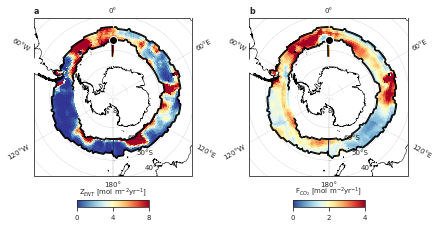

In [66]:
fname = '../Data/10m_coastline.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                 ccrs.PlateCarree(), lw=.5, edgecolor='k', facecolor='white')

#-------------------------------
fig=plt.figure(figsize=(18*cm1, 10*cm1))
ax = fig.add_subplot(121,projection = ccrs.Stereographic(central_latitude=-90))
from cartopy.util import add_cyclic_point

mesh=ax.pcolormesh(dic_entrain_m.lons,dic_entrain_m.lats,dic_entrain_m.where(m[:-5,:].values==True),vmin=0,vmax=8,cmap='RdYlBu_r',transform = ccrs.PlateCarree(),zorder=-1)
cb = plt.colorbar(mesh, orientation = 'horizontal', shrink=0.4, aspect = 10, pad = 0.11,ticks=[0,4,8],)
cb.ax.set_title('Z$_{ENT}$ [mol m$^{-2}$yr$^{-1}$]',fontsize=7,)
ax.add_feature(shape_feature, zorder=100)
datam, lon1 = add_cyclic_point(m, m.lon)
ax.contour(m.lon,m.lat,m,1 ,transform = ccrs.PlateCarree(),zorder=100,linewidths=1,colors='black')
ax.set_title('a',fontweight='bold', x=0,y=.99,loc='left',zorder=280,fontsize=8)
ax.plot(0,-54,marker='o',markersize=8,color='k',markeredgecolor='white',transform = ccrs.PlateCarree(),zorder=501)
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.fontsize=5

ax = fig.add_subplot(122,projection = ccrs.Stereographic(central_latitude=-90))
from cartopy.util import add_cyclic_point
mesh=ax.pcolormesh(lon1,fco2_clim_amp.lat[:],fco2_clim_amp.where(m[:,:].values==True),vmin=0,vmax=4,cmap='RdYlBu_r',transform = ccrs.PlateCarree(),zorder=-1)#'RdYlBu_r'
cb = plt.colorbar(mesh, orientation = 'horizontal', shrink=0.4, aspect = 10, pad = 0.11)
cb.ax.set_title('F$_{CO_2}$ [mol m$^{-2}$yr$^{-1}$]',fontsize=7)
ax.add_feature(shape_feature, zorder=100)
ax.plot(0,-54,marker='o',markersize=8,color='k',markeredgecolor='white',transform = ccrs.PlateCarree(),zorder=201,)
ax.set_title('b',fontweight='bold',x=0, y=.99,loc='left',zorder=280,fontsize=8)
ax.contour(m.lon,m.lat,m,1 ,transform = ccrs.PlateCarree(),zorder=100,linewidths=1,colors='black')
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.fontsize=5
